# Slow Boring Comment Analysis
A basic analysis of comments from [Slow Boring](https://www.slowboring.com/) between January and April of 2022.

Data consists of anonymized comments with basic attributes.
* `post_id` - The post on which the comment occurred
* `comment_id` - A unique id for each comment
* `user_id` - An anonymized identifier for each user
* `date` - When the comment was posted in UTC
* `hearts` - Number of hearts (i.e., likes) awarded to the comment
* `ancestor_path` - Describes the ancestors (i.e., parents) of each comment. Empty for top-level comments

The comments were fetched using the substack API that powers the website. They were then annonymized by replacing the internal ids with newly generated ones.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.style.use('dark_background')
plt.rc('font', size=16)

pd.options.display.max_rows = 200
pd.options.display.max_colwidth = 120
pd.options.display.html.use_mathjax = False

## Load Data
Load the data, perform some basic transformation, and calculate some basic statistics

In [3]:
comments = pd.read_csv('slowboring_comments_anon.csv')
comments['ancestor_path'] = (
    comments['ancestor_path']
    .fillna('')
    .map(lambda p: tuple(i for i in p.split('.') if i))
)
comments.head()

,post_id,comment_id,user_id,date,hearts,ancestor_path
0,0,0,0,2022-01-03 11:23:00,28,()
1,0,1,1,2022-01-03 11:39:52,8,()
2,0,2,0,2022-01-03 11:44:27,12,"(1,)"
3,0,3,2,2022-01-03 11:47:34,6,"(1,)"
4,0,4,1,2022-01-03 11:52:14,6,"(1, 3)"


In [4]:
len(comments)

29900

In [5]:
comments['post_id'].nunique()

212

In [6]:
comments['user_id'].nunique()

2040

In [7]:
comments['date'].min(), comments['date'].max()

('2022-01-01 15:30:49', '2022-04-30 23:57:50')

In [8]:
(comments['hearts']
 .describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
 .round(1))

count    29900.0
mean         3.2
std          6.7
min          0.0
25%          0.0
50%          1.0
75%          3.0
90%          8.0
95%         13.0
99%         30.0
max        229.0
Name: hearts, dtype: float64

In [9]:
(comments['ancestor_path']
 .map(len)
 .describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
 .round(1))

count    29900.0
mean         2.4
std          2.5
min          0.0
25%          1.0
50%          2.0
75%          3.0
90%          6.0
95%          7.0
99%         11.0
max         25.0
Name: ancestor_path, dtype: float64

## User Stats
Compute comment stats based around users

In [10]:
user_comment_counts = comments['user_id'].value_counts()
user_comment_counts

17      1508
0       1190
160      826
57       780
49       644
        ... 
1446       1
692        1
1448       1
690        1
2039       1
Name: user_id, Length: 2040, dtype: int64

In [11]:
comments_per_a_user_stats = (user_comment_counts
 .describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
 .round(1))
comments_per_a_user_stats

count    2040.0
mean       14.7
std        63.6
min         1.0
25%         1.0
50%         2.0
75%         7.0
90%        23.0
95%        55.0
99%       243.7
max      1508.0
Name: user_id, dtype: float64

In [12]:
print(comments_per_a_user_stats.drop(['std', 'count']).rename('comments / user').to_frame().T.to_markdown())

|                 |   mean |   min |   25% |   50% |   75% |   90% |   95% |   99% |   max |
|:----------------|-------:|------:|------:|------:|------:|------:|------:|------:|------:|
| comments / user |   14.7 |     1 |     1 |     2 |     7 |    23 |    55 | 243.7 |  1508 |


In [13]:
(user_comment_counts >= 100).sum()

56

In [14]:
user_comment_fracs = np.cumsum(user_comment_counts.iloc[::-1]) / user_comment_counts.sum()
user_comment_fracs = user_comment_fracs.rename('count_frac')
user_comment_fracs = user_comment_fracs.reset_index().drop(['index'], axis=1).reset_index()#['user_id']
user_comment_fracs['rank'] = user_comment_fracs['index'] / len(user_comment_fracs)
user_comment_fracs['rank_count'] = len(user_comment_fracs) - user_comment_fracs['index']
user_comment_fracs = user_comment_fracs.drop(['index'], axis=1)
user_comment_fracs

,count_frac,rank,rank_count
0,0.000033,0.000000,2040
1,0.000067,0.000490,2039
2,0.000100,0.000980,2038
3,0.000134,0.001471,2037
4,0.000167,0.001961,2036
...,...,...,...
2035,0.856054,0.997549,5
2036,0.882140,0.998039,4
2037,0.909766,0.998529,3
2038,0.949565,0.999020,2


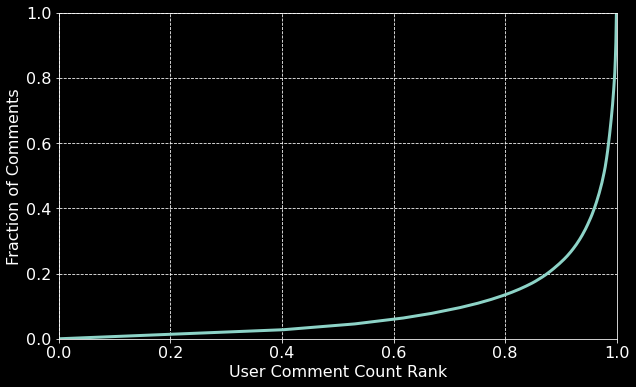

In [15]:
user_comment_fracs.plot('rank', 'count_frac', style='-', linewidth=3, figsize=(10, 6))
plt.ylabel('Fraction of Comments')
plt.xlabel('User Comment Count Rank')
plt.grid(True, linestyle='--')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.gca().get_legend().remove()


In [16]:
1 - user_comment_fracs['rank'][user_comment_fracs['count_frac'] > 0.2].iloc[0]

0.12401960784313726

In [17]:
1 - user_comment_fracs['rank'][user_comment_fracs['count_frac'] > 0.5].iloc[0]

0.02352941176470591

In [18]:
def gini_coefficient(x: pd.Series) -> float:
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

gini_coefficient(user_comment_counts)

0.8188866155157716

## User Like Stats
Compute comment stats based around likes (i.e., ❤'s)  received by users

In [19]:
comments['hearts'].max()

229

In [20]:
comments['hearts'].sum()

95423

In [21]:
user_like_sums = comments.groupby('user_id')['hearts'].sum().sort_values(ascending=False)
user_like_sums

user_id
17      4545
0       3787
263     2216
160     2004
8       1622
        ... 
1715       0
1714       0
1106       0
1712       0
1125       0
Name: hearts, Length: 2040, dtype: int64

In [22]:
likes_per_a_user_stats = (user_like_sums
 .describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
 .round(1))
likes_per_a_user_stats

count    2040.0
mean       46.8
std       198.1
min         0.0
25%         1.0
50%         5.0
75%        23.0
90%        78.0
95%       183.0
99%       841.0
max      4545.0
Name: hearts, dtype: float64

In [23]:
gini_coefficient(likes_per_a_user_stats)

0.77367679990499

In [24]:
print(likes_per_a_user_stats.drop(['std', 'count']).rename('likes / user').to_frame().T.to_markdown())

|              |   mean |   min |   25% |   50% |   75% |   90% |   95% |   99% |   max |
|:-------------|-------:|------:|------:|------:|------:|------:|------:|------:|------:|
| likes / user |   46.8 |     0 |     1 |     5 |    23 |    78 |   183 |   841 |  4545 |
